In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

In [2]:
DATA_DIR = 'tmp/data'

In [3]:
data = input_data.read_data_sets(DATA_DIR, one_hot=True)

Extracting tmp/data/train-images-idx3-ubyte.gz
Extracting tmp/data/train-labels-idx1-ubyte.gz
Extracting tmp/data/t10k-images-idx3-ubyte.gz
Extracting tmp/data/t10k-labels-idx1-ubyte.gz


In [4]:
n_feats = data.train.images.shape[1]
n_labels = data.train.labels.shape[1]
n_input_hidden_nodes = 100
n_output_hidden_nodes = 50

In [37]:
n_steps = 5000
minibatch_size = 100
step_to_print = 200
learning_rate = 0.5

In [6]:
x = tf.placeholder(tf.float32)
y_true = tf.placeholder(tf.float32)

# Dropout prob
keep_prob = tf.placeholder(tf.float32)

In [7]:
def singlelayer_nn():
    initializer = tf.contrib.layers.xavier_initializer_conv2d()
#     W = tf.Variable(tf.zeros([n_feats, n_labels]), initializer=tf.contrib.layers.xavier_initializer())
    W = tf.Variable(initializer(shape=[n_feats, n_labels]), name='W')
    b = tf.Variable(tf.zeros([n_labels]))
    
    # Regularization term
    reg_term = tf.nn.l2_loss(W)  + tf.nn.l2_loss(b)
#     reg_term = 0
    
    return tf.matmul(x, W) + b, reg_term

In [78]:
def multilayer_nn(n_input_hidden_nodes, n_output_hidden_nodes,
                  activation_f=tf.nn.sigmoid, use_xavier=True, use_dropout=True):
    # Define vars
    if use_xavier:
        initializer = tf.contrib.layers.xavier_initializer_conv2d()
        W_input = tf.Variable(initializer(shape=[n_feats, n_input_hidden_nodes]), name='W_input')
    else:
        W_input = tf.Variable(tf.zeros([n_feats, n_input_hidden_nodes]))
    b_input = tf.Variable(tf.zeros([n_input_hidden_nodes]))
    
    W_hidden = tf.Variable(tf.zeros([n_input_hidden_nodes, n_output_hidden_nodes]))
    b_hidden = tf.Variable(tf.zeros([n_output_hidden_nodes]))
    
    W_output = tf.Variable(tf.zeros([n_output_hidden_nodes, n_labels]))
    b_output = tf.Variable(tf.zeros([n_labels]))
    
    # Declare layers
    # Input layer
    preact_input = tf.matmul(x, W_input) + b_input
    act_input = activation_f(preact_input)
    act_input = preact_input
    
    # Hidden layer
    preact_hidden = tf.matmul(act_input, W_hidden) + b_hidden
    act_hidden = activation_f(preact_hidden)
    
    # Dropout
#     if use_dropout:
    act_hidden = tf.nn.dropout(act_hidden, keep_prob)

    # Output layer
    preact_output = tf.matmul(act_hidden, W_output) + b_output
    act_output = activation_f(preact_output)

    # Regularization term
    reg_term = tf.nn.l2_loss(W_input)  + tf.nn.l2_loss(b_input) + \
               tf.nn.l2_loss(W_hidden) + tf.nn.l2_loss(b_hidden) + \
               tf.nn.l2_loss(W_output) + tf.nn.l2_loss(b_output)
    
    return act_output, reg_term

In [67]:
def weight_decay(y_pred, reg_term, lam=0.0):
    cross_entropy = (tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_pred, labels=y_true))
                 + lam * reg_term)
    gd_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cross_entropy)
    correct_mask = tf.equal(tf.argmax(y_pred, axis=1), tf.argmax(y_true, axis=1))
    accuracy = tf.reduce_mean(tf.cast(correct_mask, tf.float32))
    
    with tf.Session() as sess:
        # Train
        init = tf.global_variables_initializer()
        sess.run(init)

        for i in range(n_steps):
            batch_xs, batch_ys = data.train.next_batch(minibatch_size)
            sess.run(gd_step, feed_dict={x: batch_xs, y_true: batch_ys, keep_prob: 0.5})

            if (i + 1) % step_to_print == 0:
                # Test
                acc = sess.run(
                    accuracy, 
                    feed_dict={x: data.test.images, y_true: data.test.labels, keep_prob: 1.0})
                print('Step {}, acc = {:.3f}'.format(i + 1, acc))
        # Test
#         acc = sess.run(
#             accuracy, 
#             feed_dict={x: data.test.images, y_true: data.test.labels, keep_prob: 1.0})
        
    return acc

### Weight decay

In [10]:
lams = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]

### For single layer:

In [192]:
y_pred, reg_term = singlelayer_nn()

In [180]:
accs = []
for lam in lams:
    acc = weight_decay(y_pred, reg_term, lam)
    print('acc = {:.3f}'.format(acc))
    accs.append(acc)

acc = 0.923
acc = 0.916
acc = 0.900
acc = 0.828
acc = 0.220
acc = 0.098
acc = 0.098
acc = 0.098


In [163]:
# Batch normalization
#        tf.nn.batch_normalization(x, mean, variance, offset, scale, variance_epsilon, name=None)
# normed = tf.nn.batch_normalization(x, mean, var, beta, gamma, 1e-3)

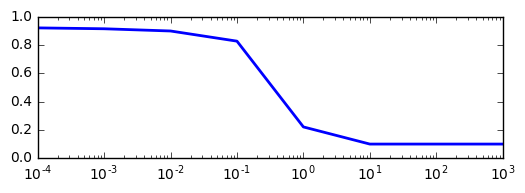

In [191]:
fig = plt.figure()
ax = fig.add_subplot(2,1,1)
line, = ax.plot(lams, accs, color='blue', lw=2)
ax.set_xscale('log')
plt.show()

### For multiple layers:

In [195]:
y_pred, reg_term = multilayer_nn(n_input_hidden_nodes, n_output_hidden_nodes)

In [196]:
accs = []
for lam in lams:
    acc = weight_decay(y_pred, reg_term, lam)
    print('acc = {:.3f}'.format(acc))
    accs.append(acc)

acc = 0.103
acc = 0.113
acc = 0.101
acc = 0.101
acc = 0.089
acc = 0.098
acc = 0.098
acc = 0.098


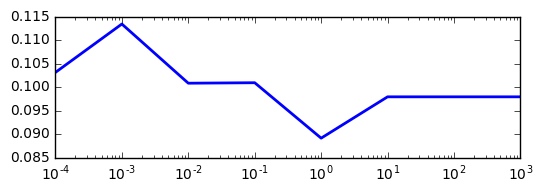

In [198]:
fig = plt.figure()
ax = fig.add_subplot(2,1,1)
line, = ax.plot(lams, accs, color='blue', lw=2)
ax.set_xscale('log')
plt.show()

### With Xavier initialization

### For single layer:

In [33]:
y_pred, reg_term = singlelayer_nn()

In [34]:
acc = weight_decay(y_pred, reg_term)
print('acc = {:.3f}'.format(acc))

Step 200, acc = 0.904
Step 400, acc = 0.904
Step 600, acc = 0.914
Step 800, acc = 0.913
Step 1000, acc = 0.918
Step 1200, acc = 0.913
Step 1400, acc = 0.919
Step 1600, acc = 0.919
Step 1800, acc = 0.920
Step 2000, acc = 0.919
Step 2200, acc = 0.921
Step 2400, acc = 0.919
Step 2600, acc = 0.921
Step 2800, acc = 0.923
Step 3000, acc = 0.921
Step 3200, acc = 0.920
Step 3400, acc = 0.921
Step 3600, acc = 0.918
Step 3800, acc = 0.923
Step 4000, acc = 0.923
Step 4200, acc = 0.916
Step 4400, acc = 0.923
Step 4600, acc = 0.923
Step 4800, acc = 0.916
Step 5000, acc = 0.922
acc = 0.922


### For multiple layers:

In [42]:
n_steps = 10000
minibatch_size = 200
step_to_print = 500
learning_rate = 0.5

In [40]:
y_pred, reg_term = multilayer_nn(n_input_hidden_nodes, n_output_hidden_nodes)

In [41]:
acc = weight_decay(y_pred, reg_term, 0)
print('acc = {:.3f}'.format(acc))

Step 500, acc = 0.892
Step 1000, acc = 0.920
Step 1500, acc = 0.928
Step 2000, acc = 0.926
Step 2500, acc = 0.933
Step 3000, acc = 0.935
Step 3500, acc = 0.939
Step 4000, acc = 0.940
Step 4500, acc = 0.946
Step 5000, acc = 0.944
Step 5500, acc = 0.946
Step 6000, acc = 0.948
Step 6500, acc = 0.951
Step 7000, acc = 0.952
Step 7500, acc = 0.951
Step 8000, acc = 0.951
Step 8500, acc = 0.952
Step 9000, acc = 0.951
Step 9500, acc = 0.953
Step 10000, acc = 0.953
acc = 0.953


## Different activation functions

### Sigmoid:

In [79]:
y_pred, reg_term = multilayer_nn(n_input_hidden_nodes, n_output_hidden_nodes)

In [80]:
acc = weight_decay(y_pred, reg_term)

Step 500, acc = 0.465
Step 1000, acc = 0.509
Step 1500, acc = 0.615
Step 2000, acc = 0.639
Step 2500, acc = 0.695
Step 3000, acc = 0.731
Step 3500, acc = 0.760
Step 4000, acc = 0.770
Step 4500, acc = 0.775
Step 5000, acc = 0.779
Step 5500, acc = 0.787
Step 6000, acc = 0.803
Step 6500, acc = 0.870
Step 7000, acc = 0.888
Step 7500, acc = 0.898
Step 8000, acc = 0.901
Step 8500, acc = 0.904
Step 9000, acc = 0.908
Step 9500, acc = 0.907
Step 10000, acc = 0.908


### Tanh

In [63]:
y_pred, reg_term = multilayer_nn(n_input_hidden_nodes, n_output_hidden_nodes, activation_f=tf.nn.tanh)

In [64]:
acc = weight_decay(y_pred, reg_term)

Step 500, acc = 0.113
Step 1000, acc = 0.103
Step 1500, acc = 0.113
Step 2000, acc = 0.113
Step 2500, acc = 0.113
Step 3000, acc = 0.103
Step 3500, acc = 0.113
Step 4000, acc = 0.113
Step 4500, acc = 0.113
Step 5000, acc = 0.113
Step 5500, acc = 0.113
Step 6000, acc = 0.113
Step 6500, acc = 0.113
Step 7000, acc = 0.113
Step 7500, acc = 0.103
Step 8000, acc = 0.113
Step 8500, acc = 0.113
Step 9000, acc = 0.113
Step 9500, acc = 0.113
Step 10000, acc = 0.113


### RELU

In [76]:
y_pred, reg_term = multilayer_nn(n_input_hidden_nodes, n_output_hidden_nodes, activation_f=tf.nn.relu)

In [77]:
acc = weight_decay(y_pred, reg_term)

Step 500, acc = 0.098
Step 1000, acc = 0.098
Step 1500, acc = 0.098
Step 2000, acc = 0.098
Step 2500, acc = 0.098
Step 3000, acc = 0.098
Step 3500, acc = 0.098
Step 4000, acc = 0.098
Step 4500, acc = 0.098
Step 5000, acc = 0.098
Step 5500, acc = 0.098
Step 6000, acc = 0.098
Step 6500, acc = 0.098
Step 7000, acc = 0.098
Step 7500, acc = 0.098
Step 8000, acc = 0.098
Step 8500, acc = 0.098
Step 9000, acc = 0.098
Step 9500, acc = 0.098
Step 10000, acc = 0.098
